# MLB Qualifying Offer Analysis: Inspired by 2025 Trent Grisham
### Scott Lehrfeld

To begin, I would like to acknoledge I have no problem with Trent Grisham. I would say indifferent is the strongest word I would use. My friend however does not feel this way. As a Yankees fan he was dissapointed Grisham was offered the qualifying offer (QO), and irate that he accepted it. His passion piqued my interest, as I was not sure if there was a fair way to judge a team for their decision on when to offer this special deal. It has only existed since 2012, (history here: https://www.mlb.com/news/history-of-mlb-qualifying-offer-decisions-c300602464) and the book is not out on how to proceed perfectly for both player and front office. In fact, 2025 marked the most ever acceptances in one season. My question is, did the Yankees make a mistake, or can my friend feel better about this front office decision?


### Project Topics

1. History of qualifying offer summary
2. Summary of year-to-year performance changed based on QO decision (including charts)
3. Accept or Reject QO prediction model (Is Grisham expected to accept, and why)
4. QO offered player performance by team
5. Team player retention based on QO
6. Grisham stat comparison to other hitters who accepted the QO

### Data

- Qulifying Offer data: Sourced from MLB.com article (Linked above)
- Player performance statistics: Baseball Savant data (https://baseballsavant.mlb.com/)
- Player IDs: https://www.smartfantasybaseball.com/tools/

# Data Dictionary 

###  Qualifying Offer Dataset
| Column       | Description                                                                        |
| ------------ | ---------------------------------------------------------------------------------- |
| `Player`     | Player name                                                                        |
| `Year`       | Season in which the Qualifying Offer was made                                      |
| `Team1`      | Team that extended the Qualifying Offer                                            |
| `Team2`      | Team the player signed with if they rejected and left (NaN if stayed)              |
| `Decision`   | Player decision on the QO (`Accepted`, `Rejected and Stayed`, `Rejected and Left`) |
| `Offer`      | Dollar value of the Qualifying Offer                                               |
| `Name_Clean` | Cleaned player name used for merging datasets                                      |
| `MLBID`      | Unique MLB player identifier                                                       |


### Player Performance Statistics

| Column             | Description                            |
| ------------------ | -------------------------------------- |
| `home_run`         | Home runs hit during the season        |
| `k_percent`        | Strikeout percentage                   |
| `bb_percent`       | Walk percentage                        |
| `on_base_plus_slg` | On-base plus slugging percentage (OPS) |
| `woba`             | Weighted On-Base Average               |
| `xwoba`            | Expected Weighted On-Base Average      |
| `home_run_next_year`         | Home runs in the season following the QO     |
| `k_percent_next_year`        | Strikeout percentage in the following season |
| `bb_percent_next_year`       | Walk percentage in the following season      |
| `on_base_plus_slg_next_year` | OPS in the following season                  |
| `woba_next_year`             | wOBA in the following season                 |
| `xwoba_next_year`            | xwOBA in the following season                |


### Derived Features
| Column                   | Description                                     |
| ------------------------ | ----------------------------------------------- |
| `delta_home_run`         | Change in home runs from QO year to next season |
| `delta_k_percent`        | Change in strikeout rate                        |
| `delta_bb_percent`       | Change in walk rate                             |
| `delta_on_base_plus_slg` | Change in OPS                                   |
| `delta_woba`             | Change in wOBA                                  |
| `delta_xwoba`            | Change in xwOBA                                 |


### Machine Learning Features
| Column            | Description                                             |
| ----------------- | ------------------------------------------------------- |
| `Offer_numeric`   | Numeric version of QO value used for modeling           |
| `Decision_binary` | Binary target variable (`1 = Accepted`, `0 = Rejected`) |


In [163]:
import pandas as pd
qo = pd.read_csv("Qualifying Offers history.csv")
player_ids = pd.read_csv("SFBB Player ID Map - PLAYERIDMAP.csv")
hitter_stats = pd.read_csv("stats_hitters.csv")
pitcher_stats = pd.read_csv("stats_pitchers.csv")


In [164]:
qo["Name_Clean"] = qo["Player"]
player_ids["Name_Clean"] = player_ids["PLAYERNAME"]

if "MLBID" not in player_ids.columns:
    player_ids["MLBID"] = pd.NA

df_qo = qo.merge(player_ids[["Name_Clean", "MLBID"]], on="Name_Clean", how="left")
df_qo_next_year = df_qo.copy()
df_qo_next_year["Year"] = df_qo_next_year["Year"] + 1

In [165]:
hitter_stats["Position_Type"] = "Hitter"
pitcher_stats["Position_Type"] = "Pitcher"
all_stats = pd.concat([hitter_stats, pitcher_stats], ignore_index=True)


In [166]:
df_qo["MLBID"] = pd.to_numeric(df_qo["MLBID"], errors="coerce")
df_qo["Year"] = pd.to_numeric(df_qo["Year"], errors="coerce")
df_qo_next_year["MLBID"] = pd.to_numeric(df_qo_next_year["MLBID"], errors="coerce")
df_qo_next_year["Year"] = pd.to_numeric(df_qo_next_year["Year"], errors="coerce")
all_stats["player_id"] = pd.to_numeric(all_stats["player_id"], errors="coerce")
all_stats["year"] = pd.to_numeric(all_stats["year"], errors="coerce")


In [167]:
stat_cols = ["home_run", "k_percent", "bb_percent", "on_base_plus_slg", "woba", "xwoba"]

df_qo_stats = df_qo.merge(
    all_stats,
    left_on=["MLBID", "Year"],
    right_on=["player_id", "year"],
    how="left"
)
df_qo_next_stats = df_qo_next_year.merge(
    all_stats,
    left_on=["MLBID", "Year"],
    right_on=["player_id", "year"],
    how="left"
)


In [168]:
df_qo_next_stats_aligned = df_qo_next_stats.copy()
df_qo_next_stats_aligned["Year"] = df_qo_next_stats_aligned["Year"] - 1

next_year_stats = (
    df_qo_next_stats_aligned[
        ["MLBID", "Year"] + stat_cols
    ]
    .rename(columns={col: f"{col}_next_year" for col in stat_cols})
)

In [169]:
df_qo_combined = df_qo_stats.merge(
    next_year_stats,
    on=["MLBID", "Year"],
    how="left"
)


In [170]:
qo_final = df_qo_combined.copy()

qo_final = qo_final[
    (qo_final["Year"] >= 2015) &
    (qo_final["Year"] <= 2024)
]

for col in stat_cols + [f"{col}_next_year" for col in stat_cols]:
    qo_final[col] = qo_final.apply(
        lambda row: -row[col] if row["Position_Type"] == "Pitcher" else row[col],
        axis=1
    )

In [171]:
delta_cols = {}

for col in stat_cols:
    delta_name = f"delta_{col}"
    qo_final[delta_name] = qo_final[f"{col}_next_year"] - qo_final[col]
    delta_cols[col] = delta_name

In [172]:
df_delta = qo_final.dropna(subset=[f"{col}_next_year" for col in stat_cols])

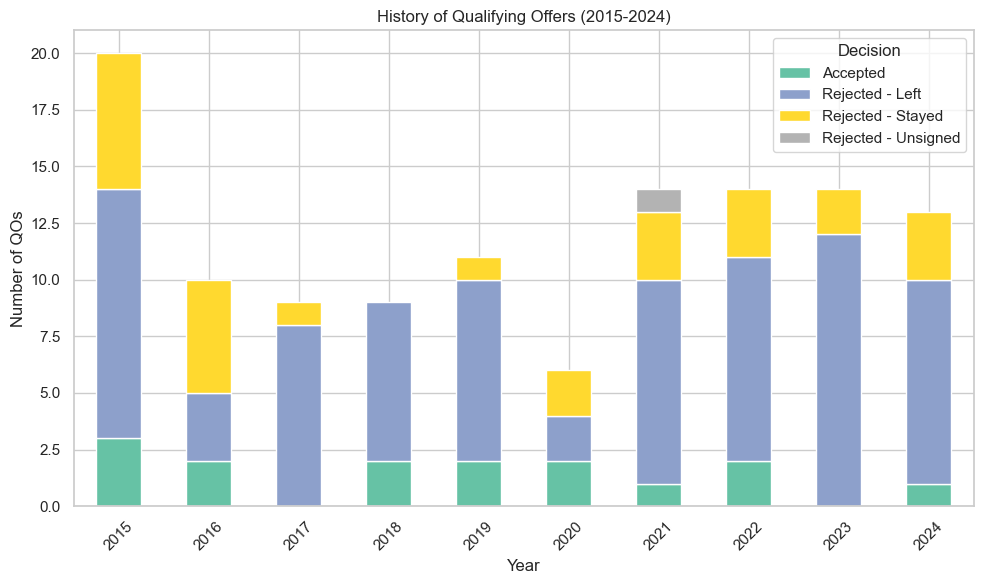

In [173]:
import matplotlib.pyplot as plt

qo_history = qo_final.groupby(["Year", "Decision"]).size().unstack(fill_value=0)

qo_history.plot(kind="bar", stacked=True, figsize=(10,6), colormap="Set2")

plt.title("History of Qualifying Offers (2015-2024)")
plt.xlabel("Year")
plt.ylabel("Number of QOs")
plt.xticks(rotation=45)
plt.legend(title="Decision")
plt.tight_layout()
plt.show()

In [174]:
summary = (
    df_delta
    .groupby("Decision")[[f"delta_{col}" for col in stat_cols]]
    .agg(["mean", "median", "count"])
    .round(4)
)
print(summary)


                  delta_home_run              delta_k_percent               \
                            mean median count            mean median count   
Decision                                                                     
Accepted                 -5.7500   -9.5    12          1.7833   1.75    12   
Rejected - Left          -2.3733   -1.0    75          1.7573   1.30    75   
Rejected - Stayed        -4.5833   -2.5    24          1.0583   0.80    24   

                  delta_bb_percent              delta_on_base_plus_slg  \
                              mean median count                   mean   
Decision                                                                 
Accepted                    0.6250   0.15    12                -0.1202   
Rejected - Left            -0.4253  -0.60    75                -0.0644   
Rejected - Stayed           0.1833   0.00    24                -0.0636   

                                delta_woba               delta_xwoba          \
      

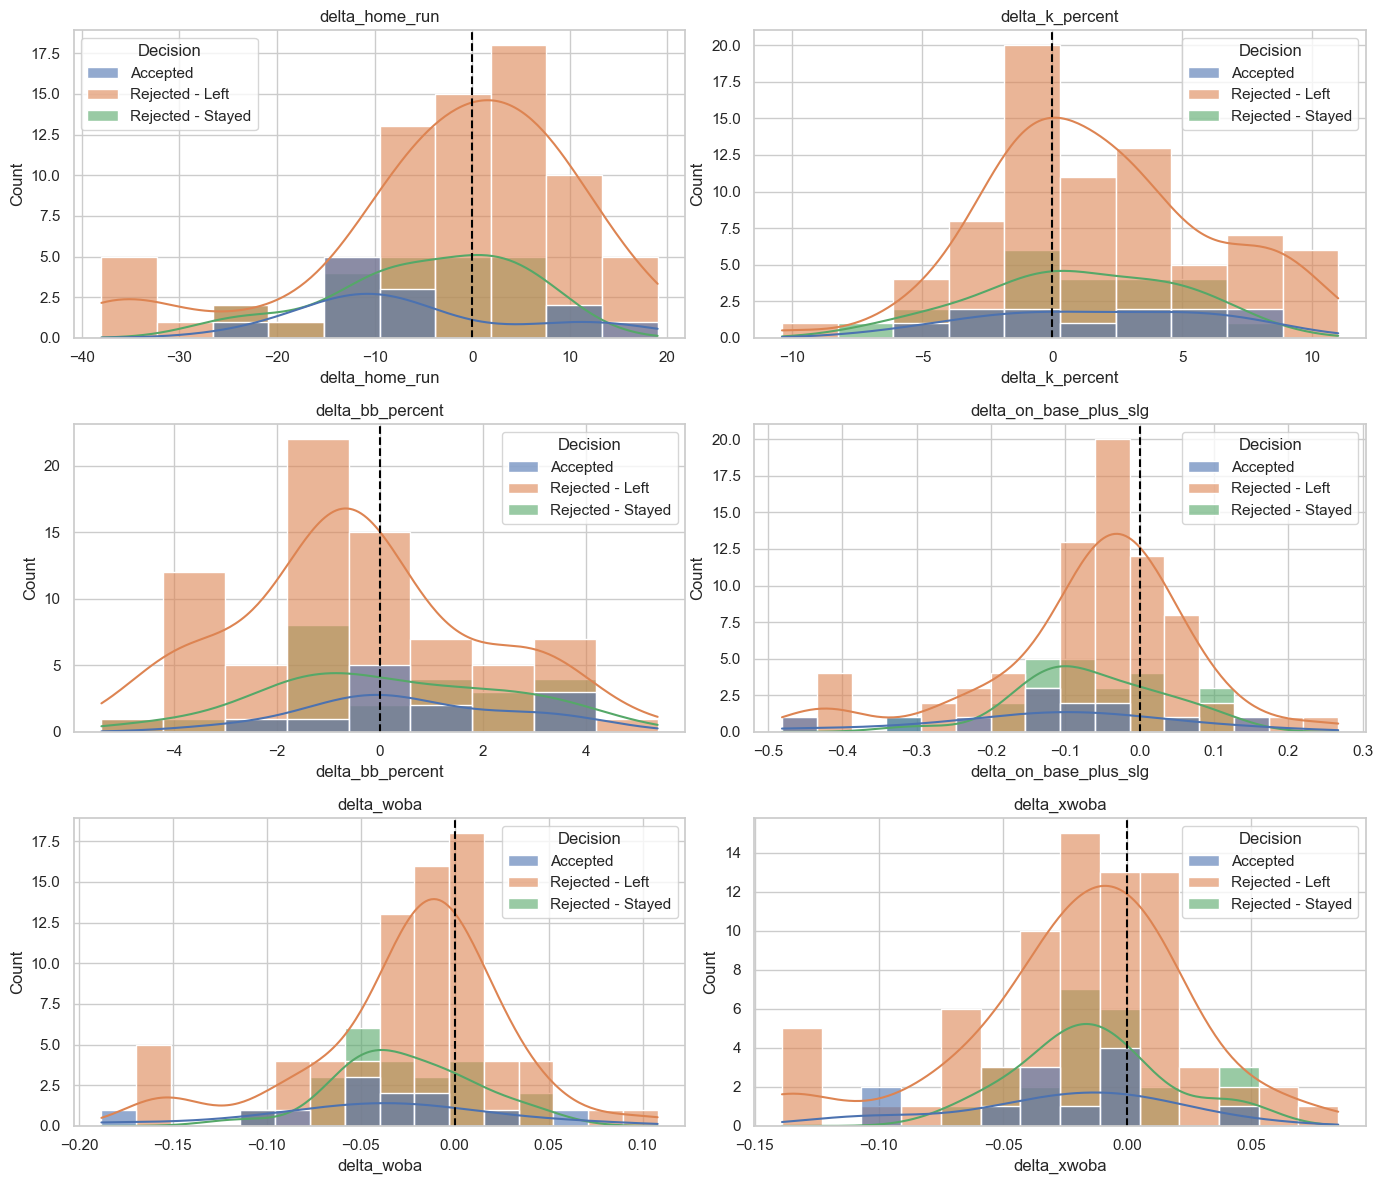

In [175]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

sns.set(style="whitegrid")

delta_cols = [f"delta_{col}" for col in stat_cols]
n_cols = 2
n_rows = math.ceil(len(delta_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4*n_rows))
axes = axes.flatten()

for ax, col in zip(axes, delta_cols):
    sns.histplot(
        data=df_delta,
        x=col,
        hue="Decision",
        kde=True,
        ax=ax,
        alpha=0.6
    )
    ax.axvline(0, color="black", linestyle="--")
    ax.set_title(col)

for ax in axes[len(delta_cols):]:
    ax.remove()

plt.tight_layout()
plt.show()


In [176]:
#Predicts accept or reject

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

df_delta["Offer_numeric"] = (
    df_delta["Offer"]
    .replace('[\$,]', '', regex=True)
    .astype(float)
)

feature_cols = stat_cols + ["Offer_numeric"]

X = df_delta[feature_cols].fillna(0)
y = df_delta["Decision"].apply(lambda x: 1 if x=="Accepted" else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


<>:10: SyntaxWarning: invalid escape sequence '\$'
<>:10: SyntaxWarning: invalid escape sequence '\$'
C:\Users\slleh\AppData\Local\Temp\ipykernel_9596\4104537297.py:10: SyntaxWarning: invalid escape sequence '\$'
  .replace('[\$,]', '', regex=True)
C:\Users\slleh\AppData\Local\Temp\ipykernel_9596\4104537297.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_delta["Offer_numeric"] = (


[[21  1]
 [ 1  0]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        22
           1       0.00      0.00      0.00         1

    accuracy                           0.91        23
   macro avg       0.48      0.48      0.48        23
weighted avg       0.91      0.91      0.91        23



In [177]:
#Would Trent Grisham accept

player_row = pd.DataFrame([{
    "home_run": 34,
    "k_percent": 23.6,
    "bb_percent": 14.1,
    "on_base_plus_slg": 0.812,
    "woba": 0.353,
    "xwoba": 0.366,
    "Offer_numeric": 22025000  
}])

player_row = player_row[feature_cols]

prediction = rf.predict(player_row)[0]
prob_accept = rf.predict_proba(player_row)[0][1]

print("Predicted Decision:", "Accepted" if prediction == 1 else "Rejected")
print(f"Probability of Accepting: {prob_accept:.2%}")

Predicted Decision: Rejected
Probability of Accepting: 4.00%


In [178]:
#The model thought his stats were to good to accept and that he could find a better offer on the market
 
accepted = df_delta[df_delta["Decision"] == "Accepted"]
rejected = df_delta[df_delta["Decision"] == "Rejected"]

for stat in ["woba", "xwoba", "on_base_plus_slg"]:
    accepted_pct = (accepted[stat] < player_row[stat].iloc[0]).mean()
    
    print(f"{stat.upper()}:")
    print(f"  Percentile among Accepted: {accepted_pct:.1%}")

WOBA:
  Percentile among Accepted: 76.9%
XWOBA:
  Percentile among Accepted: 84.6%
ON_BASE_PLUS_SLG:
  Percentile among Accepted: 61.5%


In [179]:
# Player stat changes year after QO by team

team_summary = (
    df_delta.groupby("Team1")
    .agg({
        "delta_woba": "mean",
        "delta_on_base_plus_slg": "mean",
        "Decision": "count"
    })
    .rename(columns={"Decision": "Num_QO"})
    .sort_values("delta_woba")
)
print(team_summary)


              delta_woba  delta_on_base_plus_slg  Num_QO
Team1                                                   
Angels         -0.068444               -0.194889       9
Reds           -0.057333               -0.150000       3
Twins          -0.056500               -0.150500       2
Yankees        -0.055750               -0.142750       4
Giants         -0.047714               -0.133714       7
Dodgers        -0.045182               -0.111364      11
Mariners       -0.041000               -0.103000       1
Rays           -0.041000               -0.105000       1
Orioles        -0.040333               -0.106000       6
Rangers        -0.035333               -0.098000       3
Rockies        -0.032000               -0.068500       2
Royals         -0.029750               -0.083000       4
Diamondbacks   -0.026500               -0.073000       2
Phillies       -0.022000               -0.055000       3
Blue Jays      -0.021667               -0.051833       6
Brewers        -0.021000       

In [180]:
# team retention

team_retention = (
    df_delta
    .groupby("Team1")["Decision"]
    .value_counts(normalize=True)
    .rename("Rate")
    .reset_index()
)
team_retention_pivot = team_retention.pivot(
    index="Team1",
    columns="Decision",
    values="Rate"
).fillna(0)

team_retention_pivot["Accept_Rate"] = team_retention_pivot.get("Accepted", 0)
team_retention_pivot["Reject_Rate"] = team_retention_pivot.get("Rejected", 0)

team_retention_pivot = team_retention_pivot.sort_values("Accept_Rate")

print(team_retention_pivot)


Decision      Accepted  Rejected - Left  Rejected - Stayed  Accept_Rate  \
Team1                                                                     
Angels        0.000000         0.888889           0.111111     0.000000   
Blue Jays     0.000000         0.666667           0.333333     0.000000   
Braves        0.000000         1.000000           0.000000     0.000000   
Brewers       0.000000         1.000000           0.000000     0.000000   
Cleveland     0.000000         1.000000           0.000000     0.000000   
Cardinals     0.000000         1.000000           0.000000     0.000000   
Cubs          0.000000         0.666667           0.333333     0.000000   
Diamondbacks  0.000000         1.000000           0.000000     0.000000   
Padres        0.000000         1.000000           0.000000     0.000000   
Mariners      0.000000         0.000000           1.000000     0.000000   
Nationals     0.000000         1.000000           0.000000     0.000000   
Yankees       0.000000   

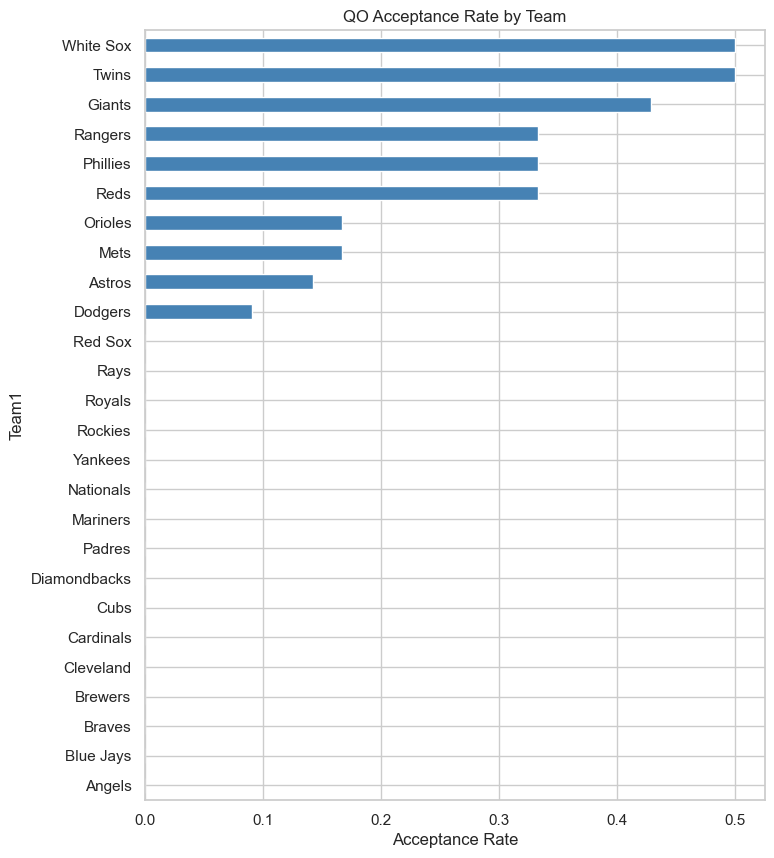

In [181]:
team_retention_pivot["Accept_Rate"].plot(
    kind="barh", figsize=(8,10), color="steelblue"
)

plt.title("QO Acceptance Rate by Team")
plt.xlabel("Acceptance Rate")
plt.show()

In [182]:
qo_accepted_hitters = qo_final[
    (qo_final["Position_Type"] == "Hitter") &
    (qo_final["Decision"] == "Accepted")
].copy()

In [183]:
rank_stats = [
    "woba",
    "xwoba",
    "on_base_plus_slg",
    "k_percent"
]

rank_results = {}

player_row = pd.DataFrame([{
    "home_run": 34,
    "k_percent": 23.6,
    "bb_percent": 14.1,
    "on_base_plus_slg": 0.812,
    "woba": 0.353,
    "xwoba": 0.366
}])

for stat in rank_stats:
    if stat == "k_percent":
        rank = (qo_accepted_hitters[stat] > player_row[stat].iloc[0]).mean()
    else:
        rank = (qo_accepted_hitters[stat] < player_row[stat].iloc[0]).mean()

    rank_results[stat] = rank

for stat, pct in rank_results.items():
    print(f"{stat}: {pct:.1%} percentile among QO acceptances")

woba: 66.7% percentile among QO acceptances
xwoba: 83.3% percentile among QO acceptances
on_base_plus_slg: 33.3% percentile among QO acceptances
k_percent: 50.0% percentile among QO acceptances


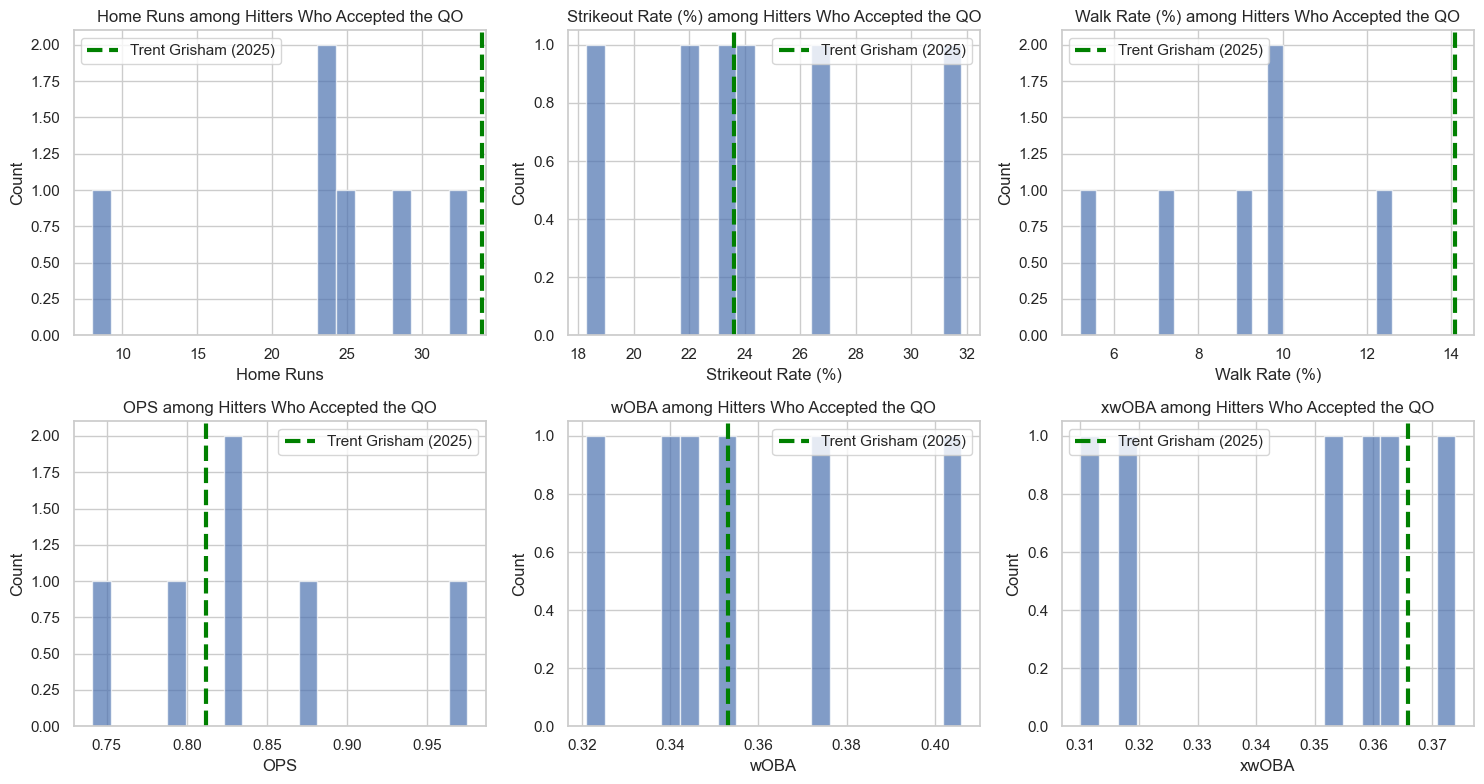

In [184]:
stats = [
    "home_run",
    "k_percent",
    "bb_percent",
    "on_base_plus_slg",
    "woba",
    "xwoba"
]

stat_names = {
    "home_run": "Home Runs",
    "k_percent": "Strikeout Rate (%)",
    "bb_percent": "Walk Rate (%)",
    "on_base_plus_slg": "OPS",
    "woba": "wOBA",
    "xwoba": "xwOBA"
}

player_name = "Trent Grisham (2025)"

n_stats = len(stats)
n_cols = 3  
n_rows = (n_stats + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for ax, stat in zip(axes, stats):
    qo_accepted_hitters[stat].dropna().hist(
        bins=20, alpha=0.7, ax=ax
    )
    ax.axvline(
        player_row[stat].iloc[0],
        linestyle="--",
        linewidth=3,
        color="green",
        label=player_name
    )
    ax.set_title(f"{stat_names[stat]} among Hitters Who Accepted the QO")
    ax.set_xlabel(stat_names[stat])
    ax.set_ylabel("Count")
    ax.legend()


for ax in axes[n_stats:]:
    ax.remove()

plt.tight_layout()
plt.show()